In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import mkl

mkl.set_num_threads(4)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [2]:
def append_ones(matrix, axis=1):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def randn(*dims):
    return np.random.randn(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def as_matrix(vector):
    return np.reshape(vector, (-1, 1))

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (examples[r, c] - ex_min) / (ex_max - ex_min)
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

def draw_rbm_filters(rbm):
    filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))
    tiles(filters)

def draw_layer_filters(layer):
    filters = np.reshape(layer.W[:-1].T, newshape=(8, -1, 28, 28))
    tiles(filters)

### Activation functions

In [3]:
def sigmoid(batch, stochastic=False):
    activations = 1.0 / (1.0 + np.exp(-batch))
    if stochastic:
        return activations > rand(*activations.shape).astype(np.float32)
    else:
        return activations

def sigmoid_derivative(batch):
    s = sigmoid(batch)
    return s * (1.0 - s)

In [4]:
def gaussian(batch, stochastic=False):
    # Gaussian activation function
    if stochastic:
        return np.random.normal(batch, 1) 
    else:
        return batch

def gaussian_derivative(batch):
    # Derivative of the gaussian activation function
    return np.ones(batch.shape)

# MNIST dataset

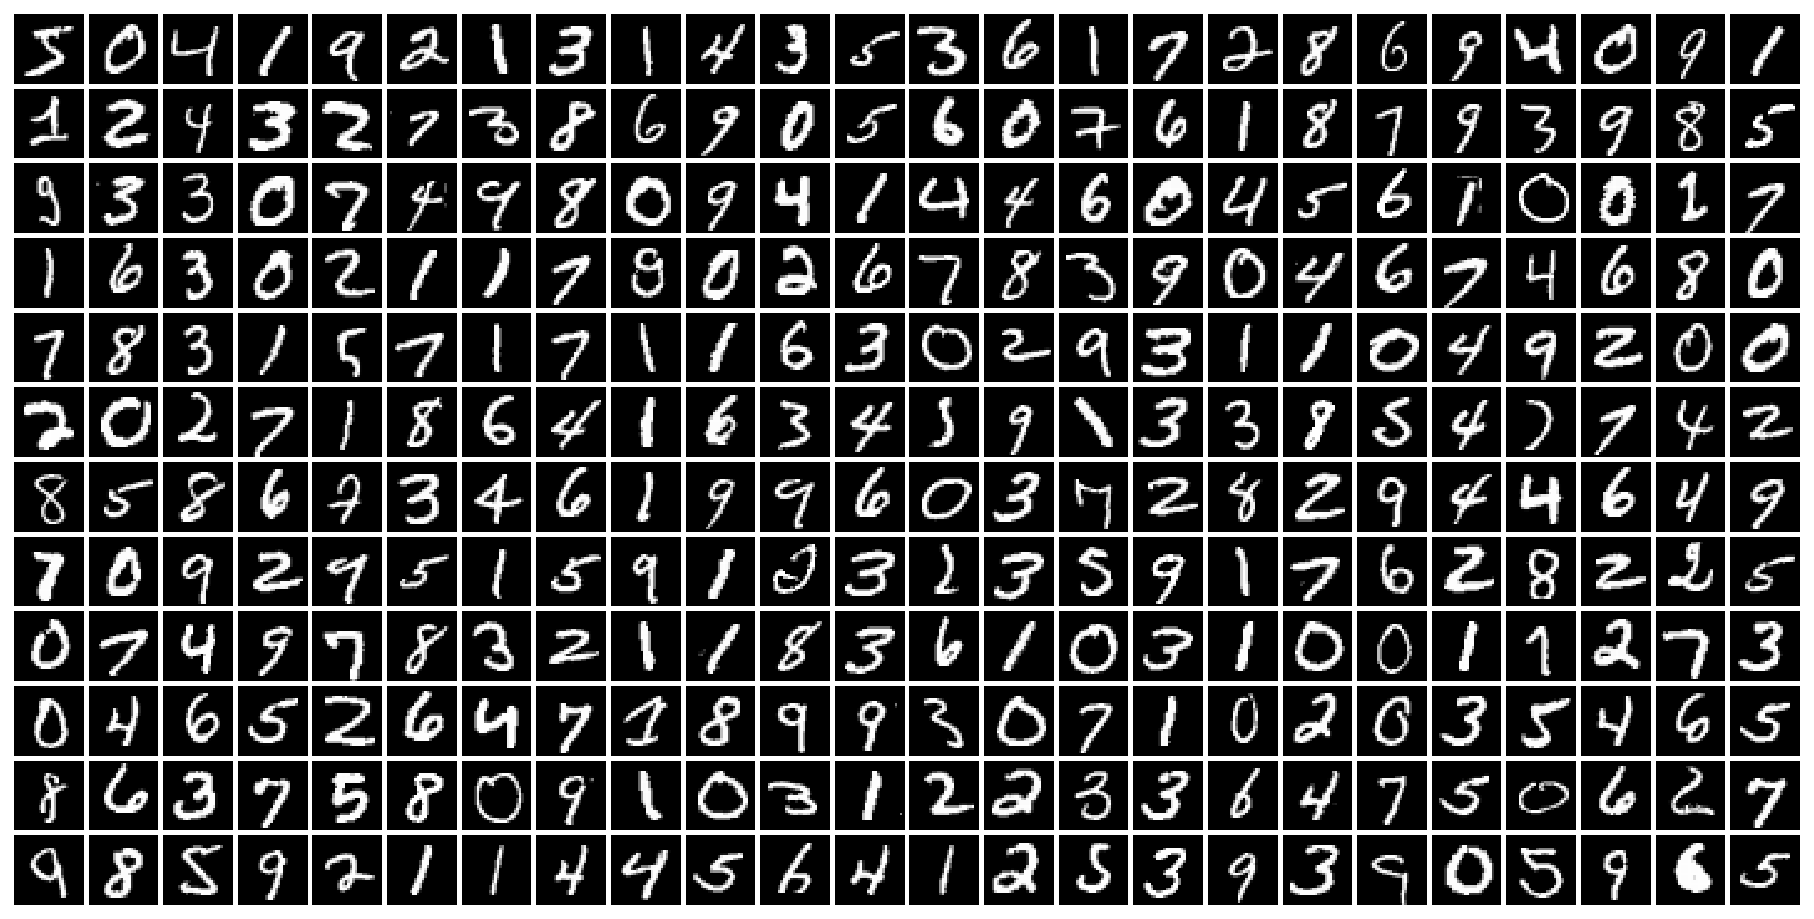

In [5]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# RBM & DBN training

In [6]:
class Rbm:
    def __init__(self, visible_size, hidden_size, visible_act_func, hidden_act_func, 
                 learning_rate, momentum, l2_penalty):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        
        self.visible_act_func = visible_act_func
        self.hidden_act_func = hidden_act_func
        
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.l2_penalty = l2_penalty
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size+1, self.hidden_size+1)).astype(np.float32)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0
        self.M = zeros(self.visible_size+1, self.hidden_size+1)

In [7]:
def cdk(rbm, minibatch, k=1):
    observations_count = minibatch.shape[0]

    positive_visible = minibatch
    negative_visible = append_ones(zeros(observations_count, rbm.visible_size))

    positive_hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    negative_hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    z = minibatch @ rbm.W[:, :-1]
    positive_hidden[:, :-1] = rbm.hidden_act_func(z)
    negative_hidden[:, :-1] = rbm.hidden_act_func(z, stochastic=True)

    for cd_i in range(k):
        negative_visible[:, :-1] = rbm.visible_act_func(negative_hidden @ rbm.W[:-1, :].T,
                                                        stochastic=True)
        z = negative_visible @ rbm.W[:, :-1]
        if cd_i < (k - 1):
            negative_hidden[:, :-1] = rbm.hidden_act_func(z, stochastic=True)
        else:
            negative_hidden[:, :-1] = rbm.hidden_act_func(z)

    rbm.M *= rbm.momentum
    rbm.M += (rbm.learning_rate / observations_count) * positive_visible.T @ positive_hidden
    rbm.M -= (rbm.learning_rate / observations_count) * negative_visible.T @ negative_hidden

    if rbm.l2_penalty is not None:
        rbm.M[:-1, :-1] = rbm.M[:-1, :-1] - rbm.learning_rate * rbm.l2_penalty * rbm.W[:-1, :-1]

    rbm.W += rbm.M;
    
def reconstuction_error(rbm, minibatch):
    observations_count = minibatch.shape[0]
    visible = zeros(observations_count, rbm.visible_size)
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    
    hidden[:, :-1] = rbm.hidden_act_func(minibatch @ rbm.W[:, :-1])
    hidden[:, :-1] = (hidden[:, :-1] > rand(observations_count, rbm.hidden_size))
    
    visible = rbm.visible_act_func(hidden @ np.transpose(rbm.W[:-1, :]))
    
    error = minibatch[:, :-1] - visible
    error = np.sum(np.square(error)) / observations_count
    
    return error

In [8]:
def propagate_up(dbn, layers_count, visible):
    for i in range(layers_count):
        visible = append_ones(dbn[i].visible_act_func(visible @ dbn[i].W[:, :-1]))
    return visible

def propagate_down(dbn, layers_count, hidden):
    for i in reversed(range(layers_count)):
        hidden = append_ones(dbn[i].hidden_act_func(hidden @ np.transpose(dbn[i].W[:-1, :])))
    return hidden

def dbn_reconstuction_error(dbn, layer_idx, minibatch):
    propagated = propagate_up(dbn, layer_idx, minibatch)
    error = reconstuction_error(dbn[layer_idx], propagated)
    return error

def train_dbn_layer(dbn, layer_idx, dataset, batch_size):
    dataset = propagate_up(dbn, layer_idx, dataset)
    
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(dbn[layer_idx], batch)
        if batch_idx % round(batches_limit / 40) == 0: print("#", end="")

def train_dbn(dbn, dataset, monitoring_set, batch_size, epochs_count):
    for layer_idx in range(len(dbn)):
        print("\nLearning layer {}".format(layer_idx))
        
        for epoch in range(epochs_count):
            print("Epoch {}:".format(epoch+1),  end="\t")

            if epoch == 5:
                dbn[layer_idx].momentum = 0.9

            start_time = time.time()
            train_dbn_layer(dbn, layer_idx, dataset, batch_size)
            elapsed = time.time() - start_time

            error = dbn_reconstuction_error(dbn, layer_idx, monitoring_set)
            print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

# Autoencoder training

In [9]:
class Layer:
    def __init__(self, visible_size, hidden_size, activation_fun, d_activation_fun, 
                 learning_rate, momentum, l2_penalty):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        
        self.activation_fun = activation_fun
        self.d_activation_fun = d_activation_fun
                
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.l2_penalty = l2_penalty
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size+1, self.hidden_size)).astype(np.float32)
        self.W[-1, :] = 0.0
        
        self.activations = None
        self.d_activations = None
        self.deltas = None

        self.M = zeros(self.visible_size+1, self.hidden_size)

In [10]:
def forward_pass(ae, batch, compute_derivatives):
    visible = batch
    
    for layer_idx, layer in enumerate(ae):
        z = visible @ layer.W
        layer.activations = append_ones(layer.activation_fun(z))
        
        if compute_derivatives and (layer_idx < len(ae) - 1):
            layer.d_activations = layer.d_activation_fun(z)
            
        visible = layer.activations

    return visible[:, :-1]

def error_backpropagate(ae, batch):
    observations_count = batch.shape[0]

    for layer_idx, layer in reversed(list(enumerate(ae))):
        if layer_idx > 0:
            prev_layer = ae[layer_idx - 1]
            visible = prev_layer.activations
            
            prev_layer.deltas = (layer.deltas @ layer.W[:-1, :].T) * prev_layer.d_activations
        else:
            visible = batch
        
        layer.M *= layer.momentum
        layer.M -= (layer.learning_rate / observations_count) * (visible.T @ layer.deltas)
        
        if layer.l2_penalty > 0:
            layer.M[:-1, :] = layer.M[:-1, :] - layer.learning_rate * layer.l2_penalty * layer.W[:-1, :]
        
        layer.W += layer.M

### Cross entropy cost

Implement cross entropy cost for deep AE. To this end:
* calculate the cross entropy cost between pixels in the input batch and their reconstructions,
* sum the cross entropy cost over all pixels and all observations in the minibatch,
* return average cost per input observation.

In [11]:
def xentropy(batch, reconstructions):
    # Cross entropy cost
    observations_count = batch.shape[0]
    total_entropy = -1 * np.sum(batch * np.log(reconstructions) + (1. - batch) * np.log(1. - reconstructions))
    mean_entropy = total_entropy / observations_count
    return mean_entropy

### Training procedure

In [12]:
def train_ae(ae, dataset, batch_size):
    batches_limit = dataset.shape[0] / batch_size
    batched_data = chunks(dataset, batch_size)
    
    for batch_idx, batch in enumerate(batched_data):
        reconstructions = forward_pass(ae, batch, True)

        # Gradient of the cross entropy cost wrt the deep AE output
        ae[-1].deltas = reconstructions - batch[:, :-1]
        
        error_backpropagate(ae, batch)
        
        if batch_idx % round(batches_limit / 40) == 0: print("#", end="")

In [13]:
def run_ae_training(ae, train_set, validation_set, batch_size, epochs_count):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch+1),  end="\t")
        
        start_time = time.time()
        train_ae(ae, train_set, batch_size)
        elapsed = time.time() - start_time

        xe = xentropy(validation_set[:, :-1], forward_pass(ae, validation_set, False))
        print("\telapsed: {0:>2.2f}s, cross-entropy: {1:>2.2f}".format(elapsed, xe))

    print("Training finished!")

###  Initializing AE with DBN weights

Implement initialization of AE weights (and biases) using weights (and biases) from the DBN layers.

Make sure that the AE weights (and biases) are **copies** of the DBN weights (and biases). You can use ```np.copy(...)``` function to copy the weights (simple assignment will make a view instead of a copy).

In [14]:
def initialize_ae(ae, dbn):
    # Initialization of a deep AE
    assert(len(ae) == 2*len(dbn))
    
    for i, dbn_layer in enumerate(dbn):
        ae[i].W = dbn_layer.W[:, :-1].copy()
        ae[len(ae) - 1 - i].W = dbn_layer.W.T[:, :-1].copy()

# Autoencoder for MNIST digits

In [15]:
DATASET_SIZE = 10000 # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_images = np.random.permutation(mnist_train_images)

mnist_train_images = np.reshape(mnist_train_images[:DATASET_SIZE],
                                newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
mnist_train_images = append_ones(mnist_train_images)

monitoring_set_indeces = np.random.choice(mnist_train_images.shape[0], 512, replace=False)
monitoring_set = mnist_train_images[monitoring_set_indeces]

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = np.reshape(mnist_test_images, newshape=(-1, DIGIT_SIZE*DIGIT_SIZE))
mnist_test_images = append_ones(mnist_test_images)

In [16]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE

BATCH_SIZE = 128
EPOCHS_COUNT = 50

RBM_LEARNING_RATE = 0.1
AE_LEARNING_RATE = 0.01
AE_MOMENTUM = 0.9
L2_PENALTY = 0.0002

In [17]:
from IPython.core.display import HTML

def compare_results(ae, dbn,
                    train_set, validation_set, monitoring_set,
                    batch_size, epochs_count):
    for layer in ae:
        layer.reset()
    
    display(HTML('<h3>Plain AE training</h3>'))
    run_ae_training(ae, train_set, validation_set,
                    batch_size, epochs_count)
    
    display(HTML('<h3>Input layer filters in the plain AE</h3>'))
    draw_layer_filters(ae[0])
    
    display(HTML('<h3>Input minibatch</h3>'))
    tiles(np.reshape(validation_set[:8*24, :-1],
                     newshape=(8, 24, 28, 28)))
    
    display(HTML('<h3>Plain AE reconstructions</h3>'))
    ae_reconstructions = np.reshape(forward_pass(ae, validation_set[:8*24], False),
                                    newshape=(8, 24, 28, 28))
    tiles(ae_reconstructions)
    
    display(HTML('<h3>DBN training</h3>'))
    train_dbn(dbn, train_set, monitoring_set, batch_size, epochs_count)
    
    for layer in ae:
        layer.reset()
    
    initialize_ae(ae, dbn)
    dbn_reconstructions = np.reshape(forward_pass(ae, validation_set[:8*24, :], False),
                                     newshape=(8, 24, 28, 28))
    dbn_rec_cost = xentropy(validation_set[:, :-1],
                            forward_pass(ae, validation_set, False))
    
    display(HTML('<h3>Finetuning pretrained AE</h3>'))
    
    print("Reconstruction cost before finetuning: {0:>2.2f}\n".format(dbn_rec_cost))
    run_ae_training(ae, train_set, validation_set,
                    batch_size, epochs_count)
    
    display(HTML('<h3>First layer filters in the DBN</h3>'))
    draw_rbm_filters(dbn[0])
    
    display(HTML('<h3>Input layer filters in the pretrained & finetuned AE</h3>'))
    draw_layer_filters(ae[0])
    
    display(HTML('<h3>Input minibatch</h3>'))
    tiles(np.reshape(validation_set[:8*24, :-1],
                     newshape=(8, 24, 28, 28)))
    
    display(HTML('<h3>Pretrained AE reconstructions</h3>'))
    tiles(dbn_reconstructions)
    
    display(HTML('<h3>Finetuned AE reconstructions</h3>'))
    ae_reconstructions = np.reshape(forward_pass(ae, validation_set[:8*24], False),
                                    newshape=(8, 24, 28, 28))
    tiles(ae_reconstructions)

###  Autoencoder network

Define the autoencoder network for MNIST digits. The network structure should be suitable for pretraining with the provided DBN.

Epoch 1:	########################################	elapsed: 1.39s, cross-entropy: 206.30
Epoch 2:	########################################	elapsed: 1.37s, cross-entropy: 206.19
Epoch 3:	########################################	elapsed: 1.42s, cross-entropy: 206.16
Epoch 4:	########################################	elapsed: 1.49s, cross-entropy: 206.14
Epoch 5:	########################################	elapsed: 1.38s, cross-entropy: 206.13
Epoch 6:	########################################	elapsed: 1.40s, cross-entropy: 206.13
Epoch 7:	########################################	elapsed: 1.58s, cross-entropy: 206.12
Epoch 8:	########################################	elapsed: 1.72s, cross-entropy: 206.12
Epoch 9:	########################################	elapsed: 1.53s, cross-entropy: 206.11
Epoch 10:	########################################	elapsed: 1.39s, cross-entropy: 206.11
Epoch 11:	########################################	elapsed: 1.54s, cross-entropy: 206.10
Epoch 12:	####################

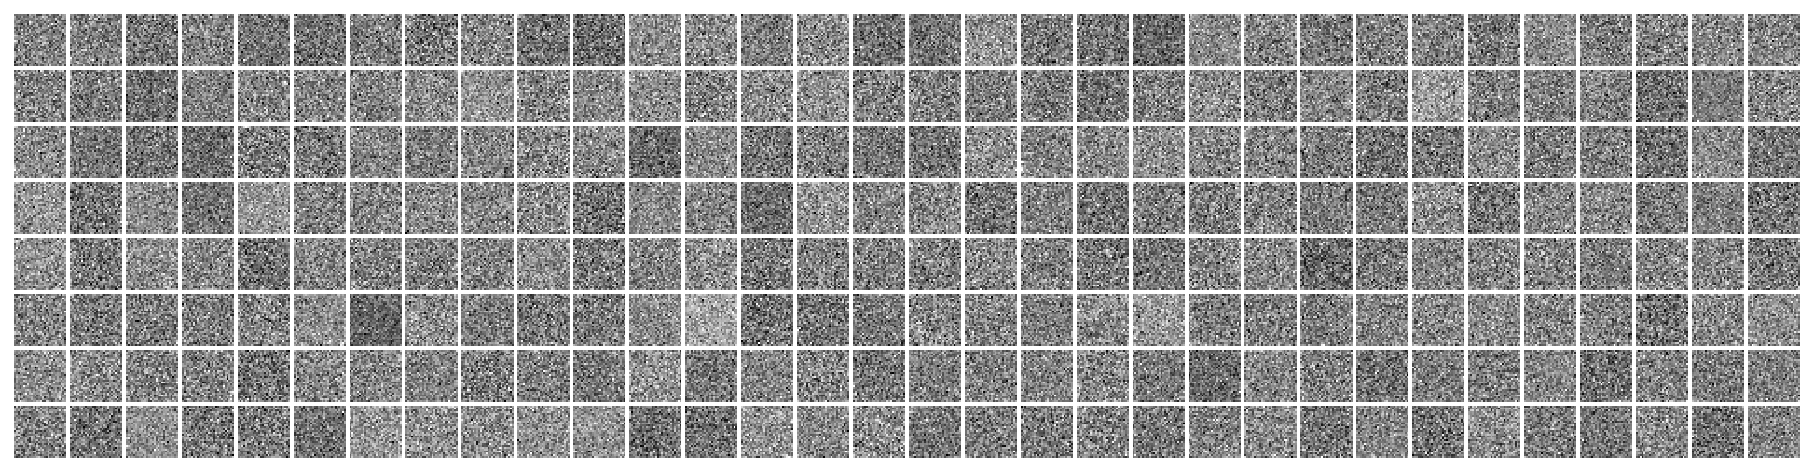

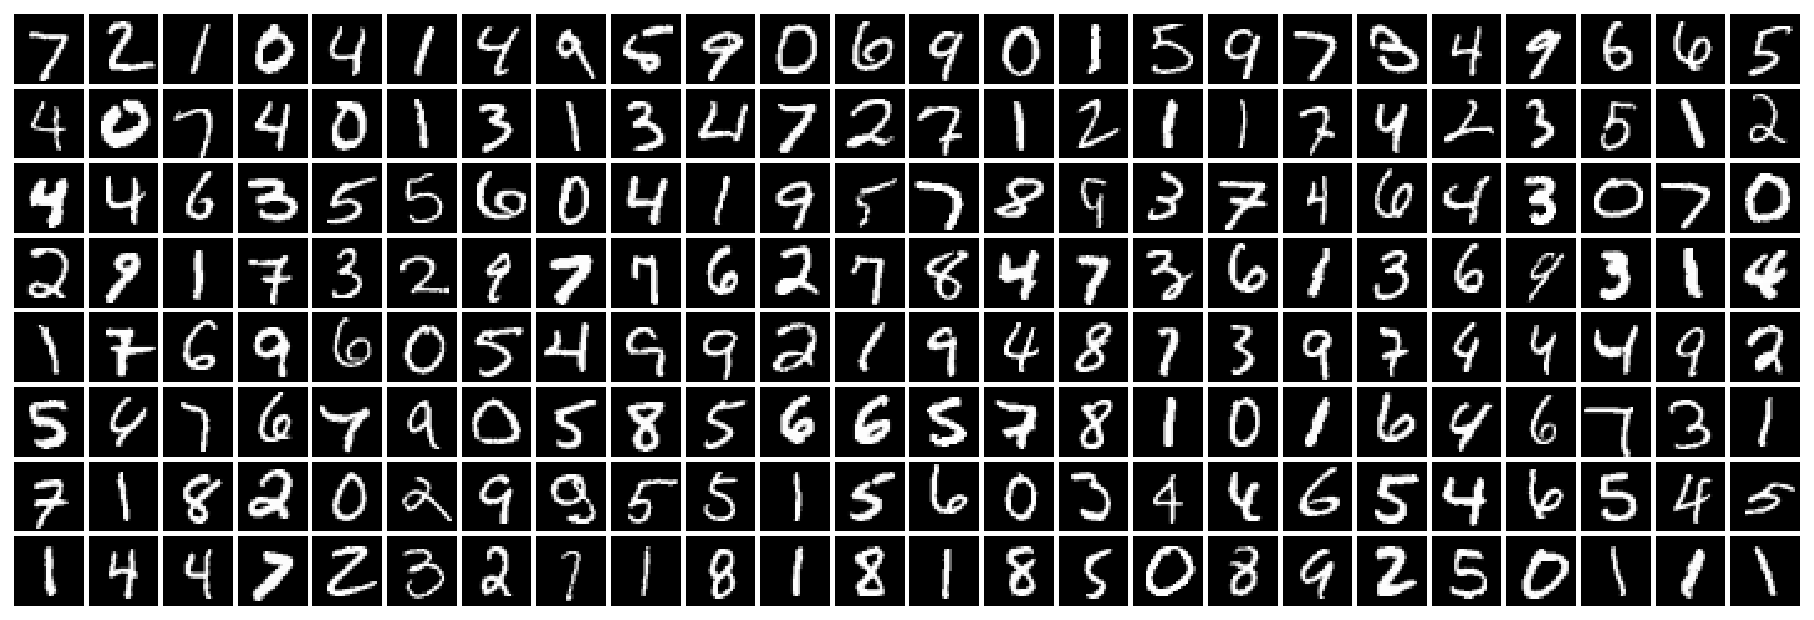

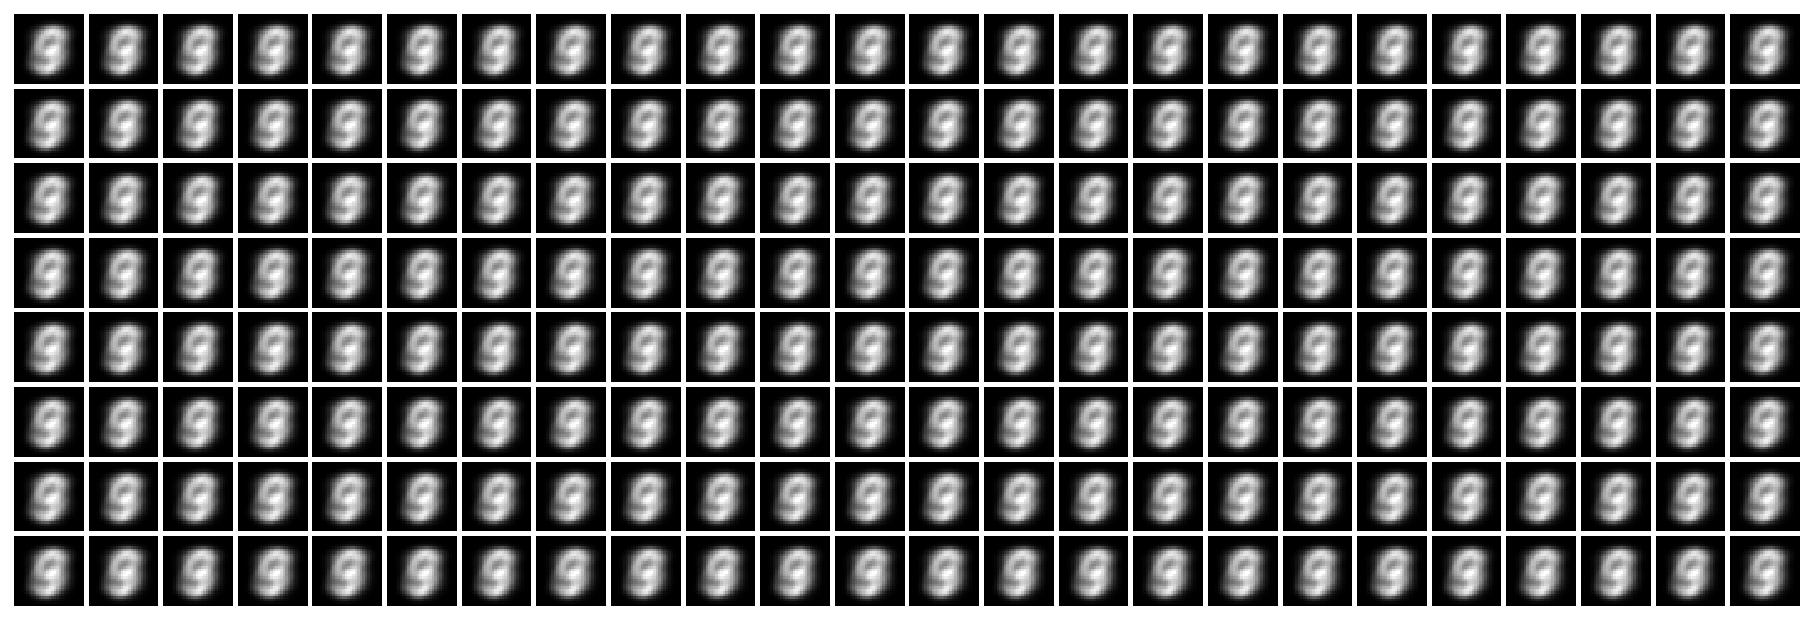


Learning layer 0
Epoch 1:	########################################	elapsed: 0.98s, reconstruction error: 31.66
Epoch 2:	########################################	elapsed: 0.97s, reconstruction error: 24.72
Epoch 3:	########################################	elapsed: 0.90s, reconstruction error: 21.31
Epoch 4:	########################################	elapsed: 0.88s, reconstruction error: 19.04
Epoch 5:	########################################	elapsed: 1.20s, reconstruction error: 17.68
Epoch 6:	########################################	elapsed: 0.98s, reconstruction error: 15.32
Epoch 7:	########################################	elapsed: 1.08s, reconstruction error: 13.84
Epoch 8:	########################################	elapsed: 1.03s, reconstruction error: 12.74
Epoch 9:	########################################	elapsed: 0.95s, reconstruction error: 12.00
Epoch 10:	########################################	elapsed: 0.93s, reconstruction error: 11.65
Epoch 11:	###############################

Epoch 38:	########################################	elapsed: 0.50s, reconstruction error: 5.22
Epoch 39:	########################################	elapsed: 0.40s, reconstruction error: 5.22
Epoch 40:	########################################	elapsed: 0.43s, reconstruction error: 5.22
Epoch 41:	########################################	elapsed: 0.38s, reconstruction error: 5.12
Epoch 42:	########################################	elapsed: 0.38s, reconstruction error: 5.13
Epoch 43:	########################################	elapsed: 0.40s, reconstruction error: 5.16
Epoch 44:	########################################	elapsed: 0.37s, reconstruction error: 5.14
Epoch 45:	########################################	elapsed: 0.34s, reconstruction error: 5.12
Epoch 46:	########################################	elapsed: 0.37s, reconstruction error: 5.14
Epoch 47:	########################################	elapsed: 0.33s, reconstruction error: 5.18
Epoch 48:	########################################	elapsed: 

Epoch 25:	########################################	elapsed: 0.29s, reconstruction error: 9.82
Epoch 26:	########################################	elapsed: 0.22s, reconstruction error: 9.83
Epoch 27:	########################################	elapsed: 0.20s, reconstruction error: 9.84
Epoch 28:	########################################	elapsed: 0.31s, reconstruction error: 9.87
Epoch 29:	########################################	elapsed: 0.22s, reconstruction error: 9.88
Epoch 30:	########################################	elapsed: 0.21s, reconstruction error: 9.90
Epoch 31:	########################################	elapsed: 0.22s, reconstruction error: 9.91
Epoch 32:	########################################	elapsed: 0.32s, reconstruction error: 9.94
Epoch 33:	########################################	elapsed: 0.23s, reconstruction error: 9.94
Epoch 34:	########################################	elapsed: 0.23s, reconstruction error: 9.94
Epoch 35:	########################################	elapsed: 

/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Reconstruction cost before finetuning: 244.01

Epoch 1:	########################################	elapsed: 1.54s, cross-entropy: 127.61
Epoch 2:	########################################	elapsed: 1.39s, cross-entropy: 120.15
Epoch 3:	########################################	elapsed: 1.36s, cross-entropy: 116.16
Epoch 4:	########################################	elapsed: 1.38s, cross-entropy: 113.41
Epoch 5:	########################################	elapsed: 1.71s, cross-entropy: 111.66
Epoch 6:	########################################	elapsed: 1.62s, cross-entropy: 110.26
Epoch 7:	########################################	elapsed: 1.49s, cross-entropy: 108.93
Epoch 8:	########################################	elapsed: 1.37s, cross-entropy: 108.11
Epoch 9:	########################################	elapsed: 1.40s, cross-entropy: 107.30
Epoch 10:	########################################	elapsed: 1.46s, cross-entropy: 106.53
Epoch 11:	########################################	elapsed: 1.45s, cross

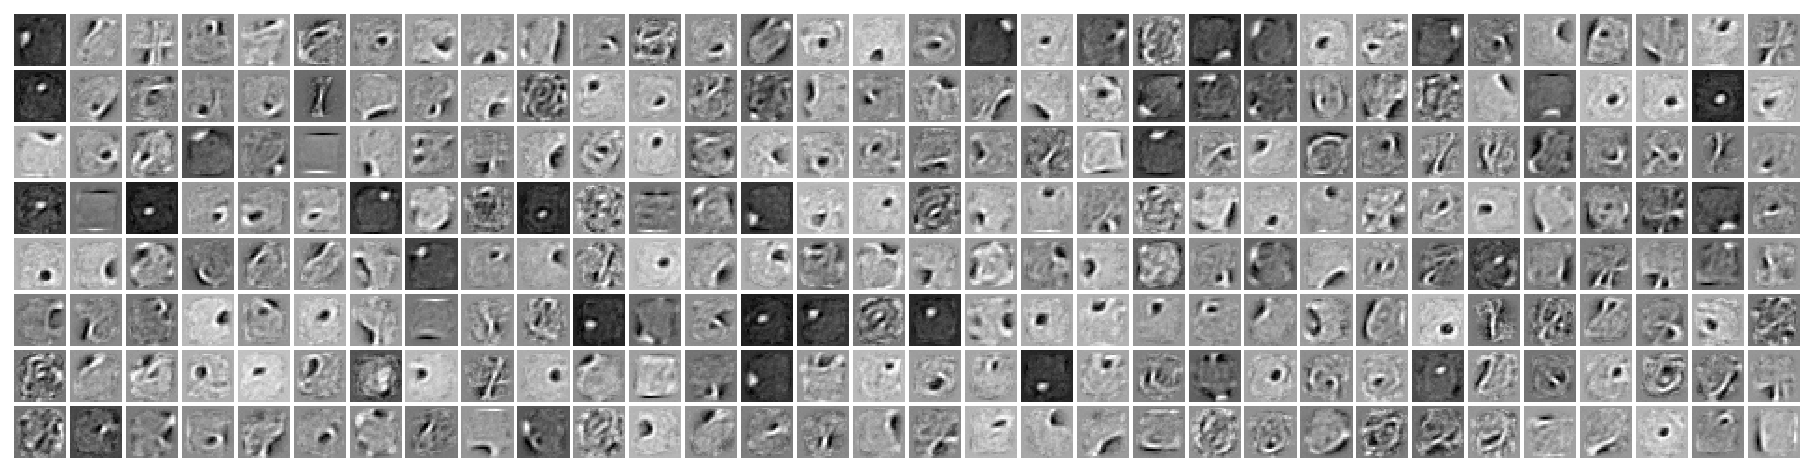

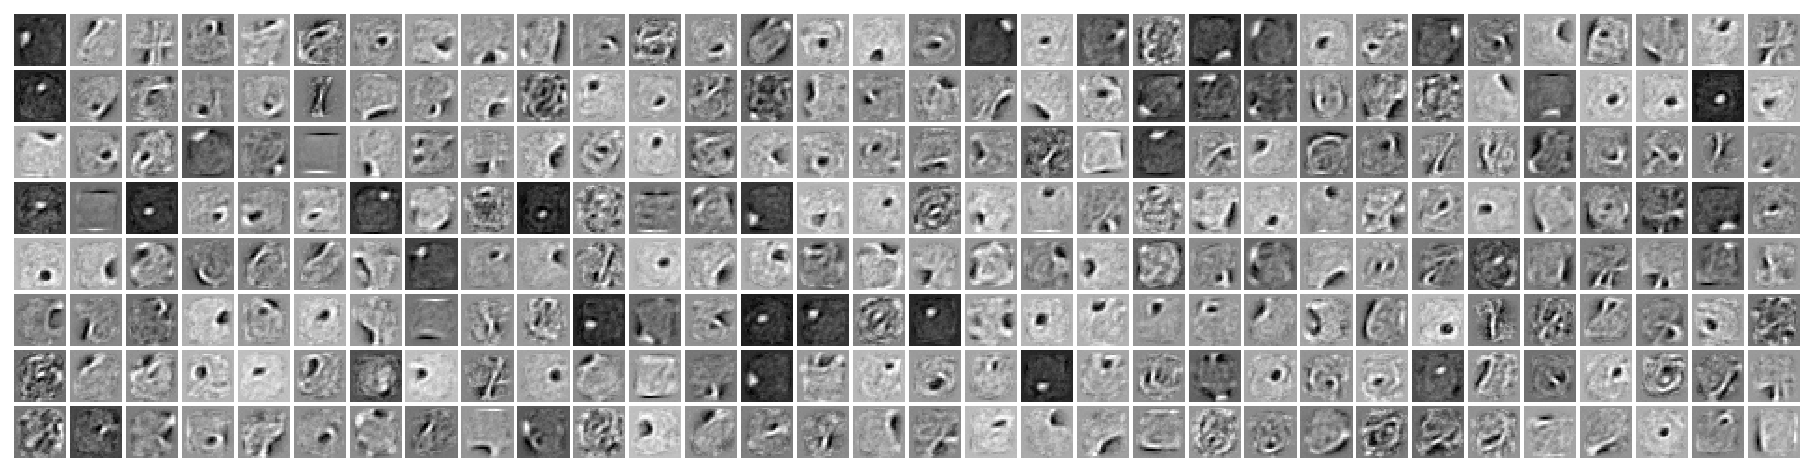

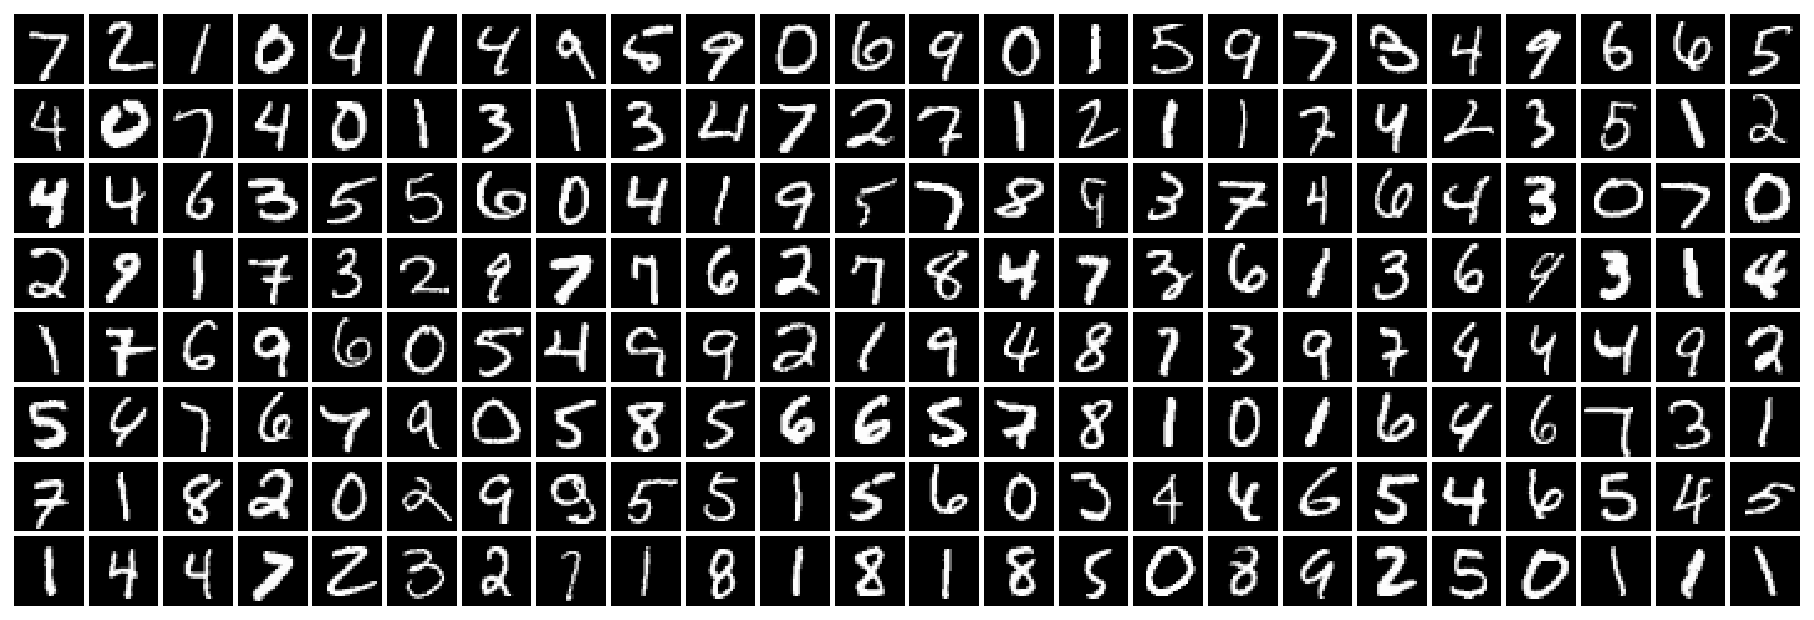

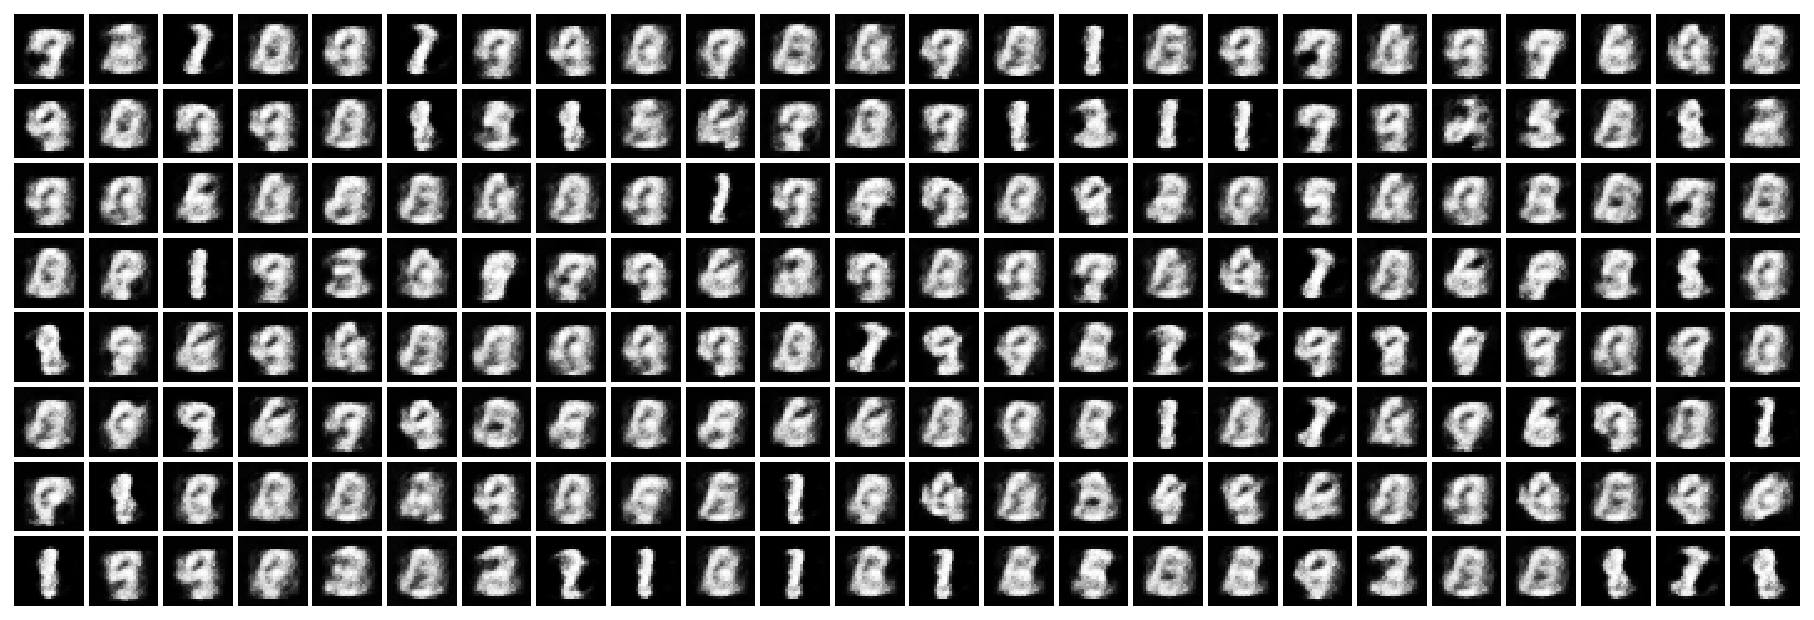

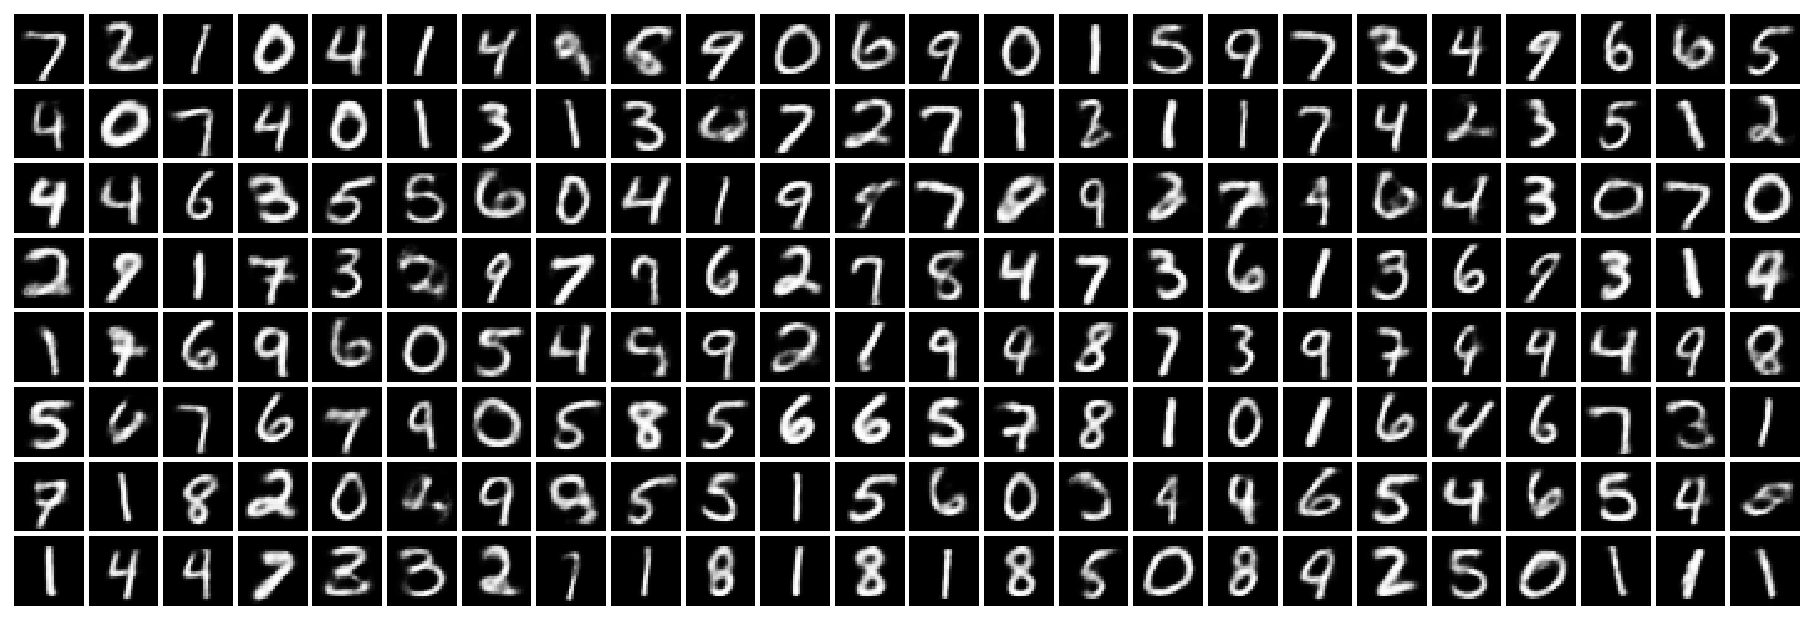

In [18]:
dbn = [
    Rbm(VISIBLE_LAYER_SIZE, 256, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY),
    Rbm(256, 128, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY),
    Rbm(128, 64, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY),
    Rbm(64, 10, sigmoid, gaussian, RBM_LEARNING_RATE / 10.0, 0.5, L2_PENALTY)
]


# AE structure
ae =  [
    Layer(VISIBLE_LAYER_SIZE, 256, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(256, 128, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(128, 64, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(64, 10, gaussian, gaussian_derivative, AE_LEARNING_RATE / 10.0, AE_MOMENTUM, L2_PENALTY),
    
    Layer(10, 64, gaussian, gaussian_derivative, AE_LEARNING_RATE / 10.0, AE_MOMENTUM, L2_PENALTY),
    Layer(64, 128, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(128, 256, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(256, VISIBLE_LAYER_SIZE, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
]

compare_results(ae, dbn,
                mnist_train_images, mnist_test_images,
                monitoring_set,
                BATCH_SIZE, EPOCHS_COUNT)